# Se utiliza el siguiente dataset: [Breast Cancer Dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset). El objetivo es construir un árbol de decisión que permita detectar el cáncer de mama. Para ello, el modelo buscará clasificar los tumores como benignos o malignos.

Empieza el projecto.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from yellowbrick.model_selection import RFECV


warnings.filterwarnings("ignore")

file = "https://raw.githubusercontent.com/Mafasamo/PortafolioML/refs/heads/main/Decision%20Tree/breast-cancer.csv"

raw_data = pd.read_csv(file)
raw_data.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Preprocesamiento:

Se verifica el número total de valores nulos y se muestra la información del conjunto de entrenamiento.

In [2]:
total_nulls = raw_data.isnull().sum().sum()
print("Total number of null values in the DataFrame:", total_nulls)

raw_data['diagnosis'].replace({"M": 1, "B": 0}, inplace=True)
target = raw_data[['diagnosis']].copy()
raw_data = raw_data.drop(["id", "diagnosis"], axis=1)
columns = raw_data.columns

X_train, X_test, y_train, y_test = train_test_split(raw_data, target, test_size=0.2, random_state=42, shuffle=True)
X_train.info()

Total number of null values in the DataFrame: 0
<class 'pandas.core.frame.DataFrame'>
Index: 455 entries, 68 to 102
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              455 non-null    float64
 1   texture_mean             455 non-null    float64
 2   perimeter_mean           455 non-null    float64
 3   area_mean                455 non-null    float64
 4   smoothness_mean          455 non-null    float64
 5   compactness_mean         455 non-null    float64
 6   concavity_mean           455 non-null    float64
 7   concave points_mean      455 non-null    float64
 8   symmetry_mean            455 non-null    float64
 9   fractal_dimension_mean   455 non-null    float64
 10  radius_se                455 non-null    float64
 11  texture_se               455 non-null    float64
 12  perimeter_se             455 non-null    float64
 13  area_se                  455 non-nul

Debido a la dificultad que tiene el algoritmo ID3 para trabajar con variables continuas, será necesario discretizar los datos. Para ello, se utilizara el metodo de clustering K-means. Con el fin de determinar el k óptimo a utilizar en el algoritmo K-means, se utilizarán los métodos "Elbow curve" y "Silhouette score".


*   Elbow curve: Para cada valor de k (número de clusters), se calcula el valor de Inertia del conjunto: $\text{Inertia} = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2$, donde:

  *   $k$ es el número de clusters,
  *   $C_i$ es el conjunto de puntos en el clúster $i$,
  *   $||x - \mu_i||^2$ es la distancia euclidiana al cuadrado entre un punto $x$ y su centroide $μ_i$
 . <br>

   A continuación, se grafican los valores de Inertia en función de los diferentes valores de k. Podrá apreciarse que a medida que aumenta la cantidad de cluesters, la Inertia disminuye. Sin embargo, la reducción de la Inertia es cada vez màs pequeña con cada cluster que se agrega. El objetivo de este método es lograr encontrar el k a partir del cual un aumento en la cantidad de clusters ya no significa una reducción importante en el valor de Inertia.
*   Silhouette score: El silhouette score de un punto es una medida de cuán similar es a su propio clúster en comparación con otros clústers.
Para cada punto i en el conjunto de datos, se calcula el silhouette score de la siguiente manera: $s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$, donde:
  *   $s(i)$ es el silhouette score de i,
  *   $b(i)$ es la distancia promedio entre el punto i y los otros puntos en el mismo cluster,
  *   $a(i)$ es la distancia promedio entre el punto i y los puntos en el clúster más cercano diferente al clúster al que i pertenece. <br>

  A continuación, se calcula el silhouette score promedio del conjunto de datos: <br>
    *   $\text{Silhouette Score} = \frac{1}{N} \sum_{i=1}^{N} s(i)$
  
  El número óptimo de clusters se elige maximizando el puntaje de silhouette score promedio.

Se aplica el mètodo "elbow curve". En caso de que los resultados obtenidos al aplicar el método no sean convicentes, se prosigue a utilizar el método "silhouette score".

A continuación se presenta un ejemplo donde se aplican ambos métodos con el fin de obtener el valor de k óptimo para discretizar el atributo "radius_worst".

Inertia K=1: 10509.32446614506
Inertia K=2: 3001.342781682906
Inertia K=3: 1671.9832727466312
Inertia K=4: 1044.794151707327
Inertia K=5: 703.5480010010334
Inertia K=6: 468.16926398690015
Inertia K=7: 350.428970794617
Inertia K=8: 321.2233106518632


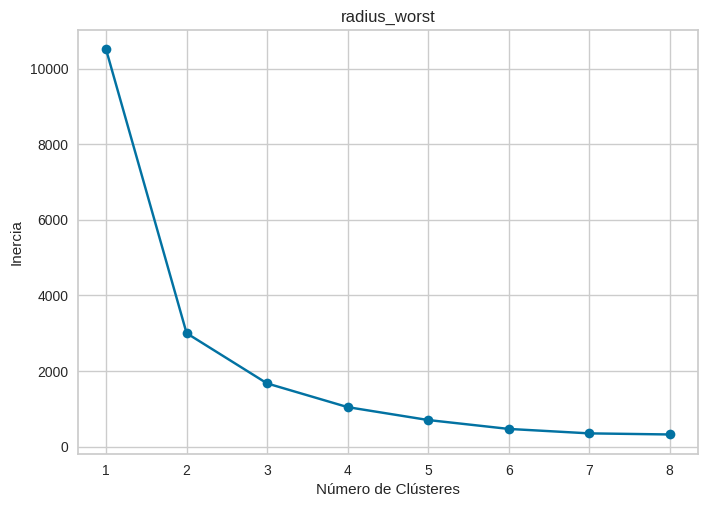

Number of bins: 2
Silhouette score: 0.6756340036431641


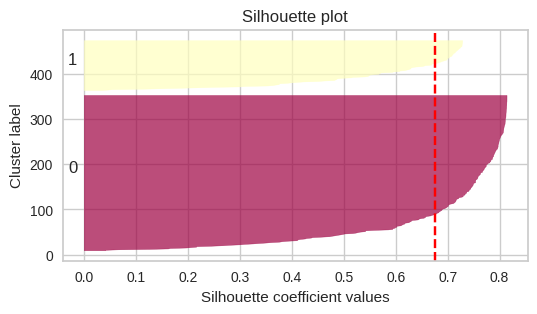

Number of bins: 3
Silhouette score: 0.5517554069489327


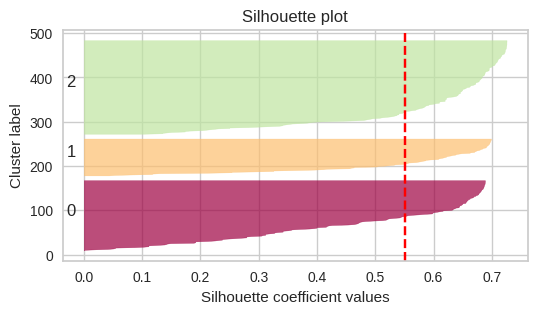

Number of bins: 4
Silhouette score: 0.5402173996589429


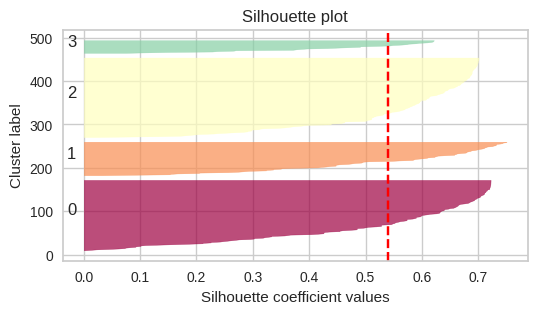

In [3]:

# Seleccionar la columna y ajustar la forma de los datos
column_data = X_train["radius_worst"].values.reshape(-1, 1)

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")

# Ajustar KMeans con un rango de números de clústeres
inertia_values = []
possible_clusters = range(1, 9)

for k in possible_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(column_data)
    inertia_values.append(kmeans.inertia_)

for k in possible_clusters:
    inertia = str(inertia_values[k-1])
    print("Inertia K=" + str(k) + ": " + inertia)

# Graficar la "Elbow curve"
plt.plot(possible_clusters, inertia_values, marker='o')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.title('radius_worst')
plt.show()

def plot_silhouette_analysis(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, labels)
    sample_silhouette_values = silhouette_samples(data, labels)

    fig, ax1 = plt.subplots(1, 1, figsize=(6, 3))

    # Gráfico de la silueta
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    print("Number of bins: " + str(n_clusters))
    print("Silhouette score: " + str(silhouette_avg))
    plt.show()

# Graficar análisis de silueta para diferentes números de clústeres
for n_clusters in range(2, 5):
    plot_silhouette_analysis(column_data, n_clusters)





Tras ejecutar el metodo "Elbow curve" se puede apreciar que hay tres fuertes candidatos para ser el valor óptimo de k: 2, 3 y 4.
A continuación, se ejecuta el metodo "Silhouette score" utilizando los tres diferentes valores mencionados anteriormente.

Los reusltados obtenidos son los siguientes:
  *   k=2: Inertia = 3001.34, Silhouette Score = 0.67.
  *   k=3: Inertia = 1671.98, Silhouette Score = 0.55.
  *   k=4: Inertia = 1044.79, Silhouette Score = 0.54.

Se realiza una comparación entre k=2 con k=3 y entre k=3 con k=4.
  *   Incrementar el número de clusters de 2 a 3 implica una reducción del valor de Inertia de un 44,29%, y una disminución del Silhouette score de un 17,91%.
  *   Incrementar el número de clusters de 3 a 4 implica una reducción del valor de Inertia de un 37,51%, y una disminución del Silhouette score de un 1,82%.

Si bien el mayor coeficiente de Silhouette score es obtenido al utilizar dos clusters, la disminución en el valor de Inertia al usar tres clusters es considerablemente alta, por lo que se prefiere una cantidad de clusters igual a tres en lugar de dos.

En cuanto a la comparación entre K igual a tres y K igual a cuatro, también puede apreciarse una clara mejora en cuanto al valor de Inertia al utilizar cuatro clusters, mientras que el coeficiente de Silhouette score disminuye muy levemente.

Realizando una valoración de los resultados obtenidos por ambos métodos se decide utilizar un número de clusters igual a cuatro para el atributo "radius_worst".

Se aplica el mismo procedimiento para el resto de atributos.

In [4]:
clusters_per_feature  = [3,3,3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3]
features_names = columns
clusters_per_feature_series = pd.Series(clusters_per_feature, index=features_names)

Se define una funcion para crear un data transformer, donde para cada atributo se genera un KBinsDiscretizer.

In [5]:
def k_bins_discretizer(data, clusters_per_feature_series):
  transformers = []

  for column_name in columns:
    column = data[column_name]

    if column.dtype == 'float64':
      transformer_name = 'discretize_' + column_name.replace('_', '')
      transformer = (transformer_name,
                      KBinsDiscretizer(n_bins=clusters_per_feature_series[column_name], encode='ordinal', strategy='kmeans'),
                      [column_name])
      transformers.append(transformer)

  discretizer = ColumnTransformer(
  transformers=transformers,
  remainder='passthrough',
  verbose_feature_names_out=False,
  ).set_output(transform="pandas")

  discretizer.fit(data)
  return discretizer

Discretización de los datos.

In [6]:
discretizer = k_bins_discretizer(X_train, clusters_per_feature_series)

X_train_indexes = X_train.index
X_test_indexes = X_test.index

X_train = discretizer.transform(X_train)
X_test = discretizer.transform(X_test)

Normalización de los datos.

In [7]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train_indexes, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test_indexes, columns=X_test.columns)

Se utiliza RFECV junto a un clasificador SVC para reducir la dimensionalidad de los datos, eliminando en cada iteración los atributos menos importantes mediante un proceso de Cross-Validation, hasta encontrar el subconjunto óptimo de atributos.

Número de atributos seleccionados: 16


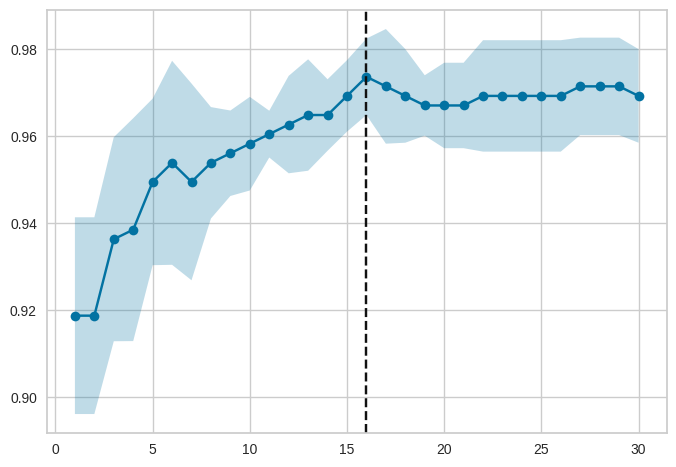

<Figure size 560x400 with 0 Axes>

In [8]:
estimator = SVC(kernel='linear')

# Se crea el objeto RFECV y se ajusta a los datos de entrenamiento
selector = RFECV(estimator, step=1, cv=5, scoring='accuracy')
selector.fit(X_train, y_train)

# Se imprime el número de características seleccionadas
print("Número de atributos seleccionados:", selector.n_features_)

# Gráfica
plt.figure(figsize=[5.6, 4])
plt.show()

In [9]:
selected_feature_indices = selector.support_
selected_feature_names = X_train.columns[selected_feature_indices]

# Crear un DataFrame con solo los atributos seleccionados
X_train = X_train[selected_feature_names]
X_test = X_test[selected_feature_names]
X_train.head(5)

,radius_mean,area_mean,concavity_mean,concave points_mean,radius_se,area_se,concave points_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst
68,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.333333,0.0,0.5,0.0,0.5,0.5,1.0,0.5,1.0
181,1.0,0.5,1.0,1.0,0.333333,0.5,0.5,0.333333,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0
63,0.0,0.0,0.0,0.0,0.333333,0.0,0.5,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
248,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.5
60,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5


## Construcción del modelo, entrenamiento y testeo:

El algoritmo ID3 utiliza la ganancia de información como métrica para seleccionar el mejor atributo en cada paso de construcción del árbol. El objetivo es maximizar la ganancia de información, lo que implica minimizar la entropía en los subconjuntos resultantes después de la división.

Entropía: Sea $S$ un conjunto de ejemplos, $C$ una función objetivo que
toma los valores $c_0…c_n$:
$\text{Entropy(S)} = - \sum_{c_i \in C} P_{c_i} * log(P_{c_i})$, donde:
*   $P_{c_i}$ es la proporción de ejemplos $x \in S, f(x) = c_i$






In [10]:
def entropy(feature):
    values, counts = np.unique(feature, return_counts=True)
    entropy_value= 0
    for i in range(len(values)):
        entropy_value -= (counts[i] / np.sum(counts)) * np.log2(counts[i] / np.sum(counts))
    return entropy_value

Se define la Ganancia de Información de un atributo A sobre una
muestra S:
$\text{Information Gain(S,A)} = {Entropy(S)} - \sum_{v \in Val(A)} \frac {||S_v||}{S}$

In [11]:
def information_gain(data, feature, global_entropy):
    values, counts = np.unique(data[feature], return_counts=True)
    instance_feature_entropy = 0
    for i in range(len(values)):
        instance_feature_entropy = instance_feature_entropy + (counts[i] / np.sum(counts)) * feature_entropy(data, feature, values[i])
    instance_feature_information_gain = global_entropy - instance_feature_entropy
    return instance_feature_information_gain

In [12]:
def feature_entropy(data, feature, value):
    entropy_value = entropy(data.where(data[feature]==value).dropna()["Target"])
    return entropy_value

def most_common_value(target):
  return np.unique(target)[np.argmax(np.unique(target, return_counts=True)[1])]

most_common_value_target = most_common_value(y_train)
print(most_common_value_target)

0


Se define el algoritmo ID3.

In [13]:
def id3_algorithm(data, target, features, min_samples_split, min_split_gain):
  most_common_value_target = most_common_value(target)
  # Casos base:

  # Si la cantidad mínima de ejemplos es menor a "min_samples_split":
  if len(data) < min_samples_split:
    return most_common_value_target

  # Si el valor de la columna target es único:
  elif (len(target.value_counts())) <= 1:
    #print(target.nunique().size)
    return target.iloc[0]

  # Si no quedan más atributos:
  elif len(features) == 0:
    return most_common_value_target

  else:
      data["Target"] = target
      # Se calcula ganancia de información de todos los atributos:
      features_gain = []
      global_entropy = entropy(target)

      for feature in features:
          features_gain.append(information_gain(data, feature, global_entropy))
      # Se calcula índice de atributo con mayor ganancia de información:
      best_feature_index = np.argmax(features_gain)
      # Si ningún atributo llega a la ganancia mínima requerida "min_split_gain":
      if (features_gain[best_feature_index] < min_split_gain):
          return most_common_value_target

      # Si al menos un atributo llega a la ganancia mínima requerida "min_split_gain":
      else:
          # Se selecciona atributo con mayor ganancia de información:
          best_feature = features[best_feature_index]

          # Se crea nodo raíz:
          tree = {best_feature: {}}

          sub_features = [i for i in features if i != best_feature]
          for value in np.unique(data[best_feature]):
              sub_data = data.where(data[best_feature] == value).dropna()
              sub_data = sub_data.drop(columns=[best_feature])
              if len(sub_data) == 0:
                tree[best_feature][value] = most_common_value_target
              else:
                sub_target = sub_data.Target
                sub_data = sub_data.iloc[:,:-1]
                sub_tree = id3_algorithm(sub_data, sub_target, sub_features, min_samples_split, min_split_gain)
                tree[best_feature][value] = sub_tree
          return tree

In [14]:
def predict(features_list, tree, default = 0):
  # Se recorre la lista de atributos.
  for key in list(features_list.keys()):
    # Para cada atributo se verifica si es el atributo raíz.
    if key in list(tree.keys()):
      # Se evalúa si existe alguna rama con el valor "arbol[key][lista_atributos[key]". En caso contrario se devuelve 0 (B).
      try:
        result = tree[key][features_list[key]]
      except:
        return default
      result = tree[key][features_list[key]]
      # Se evalúa si es un nodo o una hoja. En caso de ser un nodo se vuelve a aplicar IDE3 con los parámetros actualizados, y si es una hoja se devuelve su valor.
      if isinstance(result, dict):
        return predict(features_list, result)
      else:
        return result

def fit(df, target, min_samples_split, min_split_gain):
  features = df.columns.values.tolist()
  return id3_algorithm(df, target, features, min_samples_split, min_split_gain)

def get_prediction(df, tree):
  return df.apply(predict, axis=1, args=(tree,  0))

A continuación se utilizan varias combinaciones de dos hiperparámetros: min_samples_split y min_split_gain. Se divide el conjunto de datos en entrenamiento y validación, luego se itera sobre los posibles valores de estos hiperparámetros, entrenando un modelo para cada combinación. Para cada modelo, se evalúa la precisión en el conjunto de validación, se almacenan los resultados y se busca la mejor combinación que maximice la precisión.

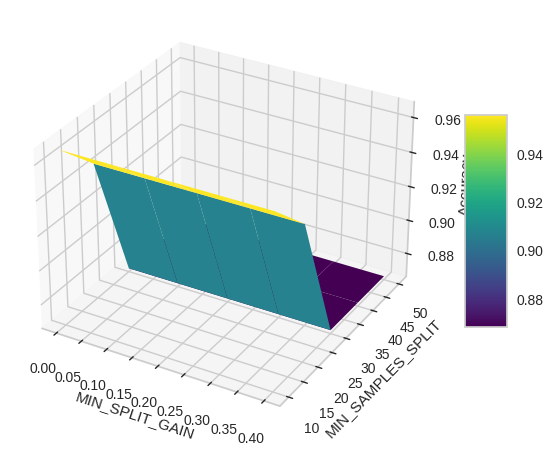

Mejor accuracy: 0.967032967032967
Mejor min_samples_split: 10
Mejor min_split_gain: 0.0


In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Se definen los valores para los hiperparámetros a probar
min_samples_split_values = [10, 20, 30, 40, 50]
min_split_gain_values = [0.0, 0.1, 0.2, 0.3, 0.4]

best_accuracy = 0
best_min_samples_split = 10
accuracies = []

# Se utiliza el conjunto de validación para evaluar las combinaciones de hiperparámetros
for min_samples_split in min_samples_split_values:
    for min_split_gain in min_split_gain_values:
        X_val_copy = X_val.copy()  # Copiar los datos originales
        y_val_copy = y_val.copy()
        tree = fit(X_val_copy, y_val_copy, min_samples_split, min_split_gain)

        # Evaluar en el conjunto de validación
        y_pred_val = get_prediction(X_val, tree)
        accuracy_val = accuracy_score(y_val, y_pred_val)

        accuracies.append((min_samples_split, min_split_gain, accuracy_val))
        #print(accuracy_val)
        #print(best_accuracy)
        #print(min_samples_split)
        #print(best_min_samples_split)

        if accuracy_val == best_accuracy:
            if min_samples_split > best_min_samples_split:
                best_accuracy = accuracy_val
                best_min_samples_split = min_samples_split
                best_min_split_gain = min_split_gain

        if accuracy_val > best_accuracy:
            best_accuracy = accuracy_val
            best_min_samples_split = min_samples_split
            best_min_split_gain = min_split_gain

accuracies = np.array(accuracies)

# Se genera un gráfico que muestra la variación de la precisión del modelo en función de los valores de
# min_samples_split y min_split_gain
unique_min_split_gain = np.unique(accuracies[:, 1])
unique_min_samples_split = np.unique(accuracies[:, 0])

Z = np.zeros((len(unique_min_samples_split), len(unique_min_split_gain)))

for i, min_samples_split in enumerate(unique_min_samples_split):
    for j, min_split_gain in enumerate(unique_min_split_gain):
        match = accuracies[(accuracies[:, 0] == min_samples_split) & (accuracies[:, 1] == min_split_gain), 2]
        if match.size > 0:
            Z[i, j] = match[0]

X, Y = np.meshgrid(unique_min_split_gain, unique_min_samples_split)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('MIN_SPLIT_GAIN')
ax.set_ylabel('MIN_SAMPLES_SPLIT')
ax.set_zlabel('Accuracy')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

print("Mejor accuracy:", best_accuracy)
print("Mejor min_samples_split:", best_min_samples_split)
print("Mejor min_split_gain:", best_min_split_gain)


El mejor resultado se obtiene con MIN_SAMPLES_SPLIT = 10 y MIN_SPLIT_GAIN = 0.0.
Se entrena un modelo utilizando los valores de hiperparámetros seleccionados. Luego, se evalúa el rendimiento del modelo sobre el conjunto de prueba (X_test).

In [ ]:
MIN_SAMPLES_SPLIT = 10
MIN_SPLIT_GAIN = 0.0

X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

tree = fit(X_train_copy, y_train_copy,MIN_SAMPLES_SPLIT,MIN_SPLIT_GAIN)
y_predicted = get_prediction(X_test, tree)
accuracyID3 = accuracy_score(y_test, y_predicted)
metrics_info = metrics.classification_report(y_test, y_predicted)
print(accuracyID3)
print(metrics_info)

0.9385964912280702
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        71
           1       0.91      0.93      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



Ahora se evalúa el rendimiento utilizando un DecisionTreeClassifier de sklearn.tree.

In [ ]:
# Inicializar un DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo con los datos de entrenamiento
dt_classifier.fit(X_train, y_train)

# Predicciones con los datos de prueba
y_pred = dt_classifier.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9298245614035088
